# MAPD-B distributed processing exam: Analysis of Covid-19 papers

## Part 1: Word counter distributed algorithm

Student: Nguyen Xuan Tung

ID: 2005491

##### Library

In [1]:
#pip install fasttext
from collections import Counter
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask import delayed
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pathlib import Path
from gensim.models import KeyedVectors
from tqdm import tqdm

import matplotlib.pyplot as plt
import dask.bag as db
import numpy as np
import pandas as pd
import seaborn as sns
import dask
import time
import json
import os
import re
import nltk
import sys
import re
import time
import warnings
import nltk
 
from gensim.models.fasttext import FastText
import gensim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

 

#### Create cluster

Check the client and cores. In this case, we have 2 workers are created, each with 1 core corresponding

In [2]:
client = Client()
client

/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41345 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:43445 Dashboard: http://127.0.0.1:41345/status,Cluster Workers: 2 Cores: 2 Memory: 5.28 GB


In [3]:
print("Python Version : ", sys.version)
print("Dask Version : ", dask.__version__)

Python Version :  3.6.13 | packaged by conda-forge | (default, Sep 23 2021, 07:56:31) 
[GCC 9.4.0]
Dask Version :  2021.03.0


#### Implement

We implement a distributed algorithm to count the occurrences of all the words inside a list of documents using Bag data-structure of DASK. Here, we explain the algorithm step by step and in the end we wrap all the steps inside a single function in order to test the computational time required by the algorithm as a function of the number of cluster workers and the number of data partitions.

The algorithm is divided into two parts:

+ **Map phase** : For each document $D_i$, produce the set of intermediate pairs $(w, c_p(w))$, one for each word $w \in D_i$, where $c_p(w)$ is the number of occurrences of $w$ in $D_i$.
E.g.: (*hello*, 3)
+ **Reduce phase** : For each word $w$, gather all the previous pairs $(w, c_p(w))$ and return the final pair $(w, c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents. In other words, $c(w)$ is equal to $\sum_{k=1}^n c_{p_k}(w)$


Read paper from JSON file

Since the original folder contain too many files (over 20000 files), we made a new folder contains fewer files (2162 files).

In [4]:
path_to_json = 'Covid19_data/document_parses/preprocessed/'

files = [path_to_json+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

path_to_one_line_json='Covid19_data/document_parses/preprocessed_1'

for i in range(len(files)):
    f = open(files[i],"r")
    f_one_line = open(path_to_one_line_json+str(i)+".json","w+")
    s = f.read()
    s = s.replace('\t','')
    s = s.replace('\n','')
    s = s.replace(" ","")
    
    f_one_line.write( str( re.split("[\n]", s )[0] ) )


f_one_line.close()
f.close() 

Load the files

We use dask bag to read ad process the json data. since the format of json data does not really enforce strict structure and data types, bag objects can be seen as the pythonic version of PySpark RDDs. They hold the standard functional API like map, filter, groupby, etc..

In [5]:
filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(20) 

Create a _merge_ function to devide the paragraphs for every single paper into a unique text.

In [6]:
def merge(record):
    text=''
    for rec in record:
        text+=rec['text']
    return text

texts = js.pluck("body_text").map(merge)
texts.take(1) # body-text of the first paper

("As a consequence of the global COVID-19 pandemic, an acceleration in the implementation of telemedicine occurred in order to better triage patients while maintaining medical resources and promoting social distancing. Concurrent improvements in video conferencing technology and the convenience afforded by telemedicine have allowed virtual health practices to persist even after many clinics have begun returning to in-person practice. Nevertheless, a primary disadvantage of telemedicine remains its relative inability to perform a complete physical examination, at least not in the same manner one would in clinic. In particular, an effective otologic exam remains elusive.The ability to rapidly and effectively identify sudden sensorineural hearing loss (SSNHL) is essential. SSNHL-with an incidence in the United States of 5 to 27 per 100 000 people 1 -is one of the few true otologic emergencies requiring expedited evaluation. Current guidelines recommend the initiation of oral or intratympa

In order to apply the counter, we need to apply the stop-words. It can be applied by stopwords function. 

In [7]:
list_stopwords = stopwords.words("english")
list_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [8]:
# add more words to the stop-words list
for word in ['et','al','also','may','fig','figure']:
    list_stopwords.append(word)

pattern = re.compile(r'\b(' + r'|'.join(list_stopwords) + r')\b\s*')




The text of the documents must be sanitized (cit.) before performing analysis. So, we created a _cleaner_ function to:

   - delete special characters;

   - delete numbers;

   - delete single characters;

   - delete stop-words;
   
   - set all lowercase;
   
   - split text in strings.



In [9]:
def cleaner(text):

    text = re.sub('\W+',' ', text)                  # delete special characters (.,!)
    text = re.sub(r'\b[0-9]+\b\s*', ' ', text)      # delete numbers
    text = text.lower()                             # set all lowercase
    text = re.sub(r"\b[a-zA-Z]\b", "", text)        # remove single characters
    text = pattern.sub('', text)                    # remove stop-words
    wordlist = text.split()                         # split text in strings
    
    return wordlist

In [10]:
text_clean = texts.map(cleaner) 
map_phase = text_clean.map(Counter)

In [11]:
text_clean

dask.bag<cleaner, npartitions=20>

#### Map phase

In this section we produce the list of intermediate pairs (words and counts) in a dictionary format.

In [12]:
map_phase

dask.bag<Counter, npartitions=20>

In [13]:
%%time
results = map_phase.compute()

CPU times: user 14.4 s, sys: 1.04 s, total: 15.4 s
Wall time: 1min 8s


In [14]:
results[2]

Counter({'se': 90,
         'calcula': 1,
         'que': 100,
         'en': 173,
         'españa': 3,
         'existen': 6,
         'cerca': 1,
         'de': 479,
         'plazas': 3,
         'residenciales': 5,
         'para': 38,
         'personas': 12,
         'mayores': 7,
         'ppmm': 6,
         'con': 56,
         'una': 40,
         'ocupación': 2,
         'del': 58,
         'lo': 7,
         'casi': 2,
         'viven': 1,
         'ellas': 3,
         'respecto': 2,
         'sus': 15,
         'características': 4,
         'clínicas': 8,
         'el': 118,
         'estudio': 5,
         'la': 271,
         'fundación': 2,
         'edad': 1,
         'vida': 2,
         'sobre': 11,
         'residentes': 26,
         'centros': 28,
         'ccaa': 1,
         'las': 81,
         'describe': 2,
         'elevada': 2,
         'pluripatología': 2,
         'los': 127,
         'casos': 11,
         'tienen': 4,
         'diagnósticos': 1,
         'activo

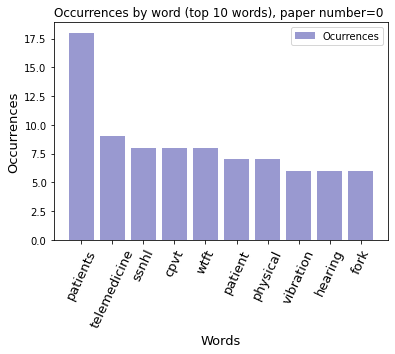

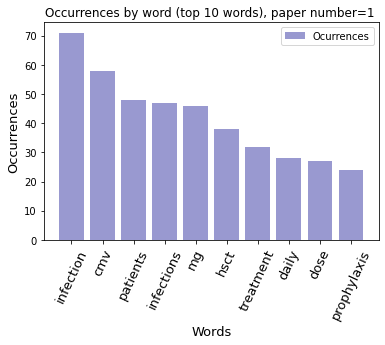

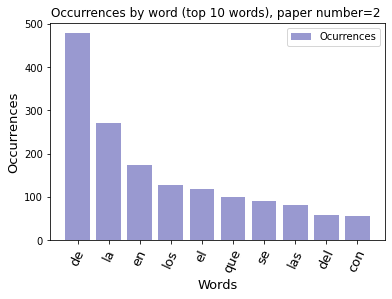

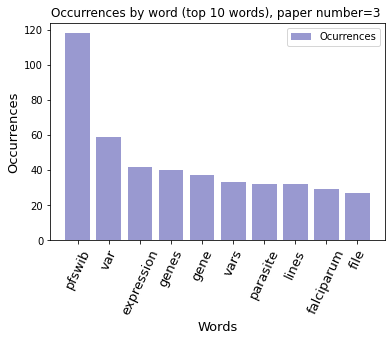

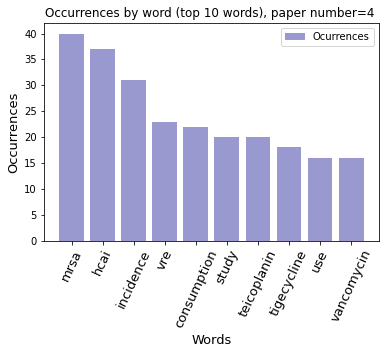

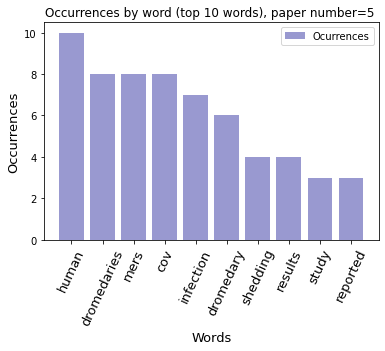

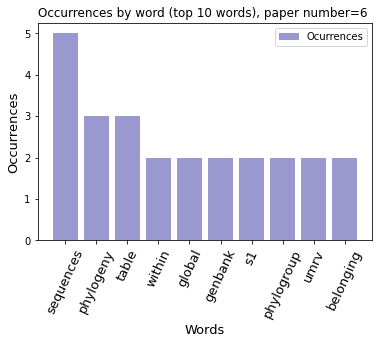

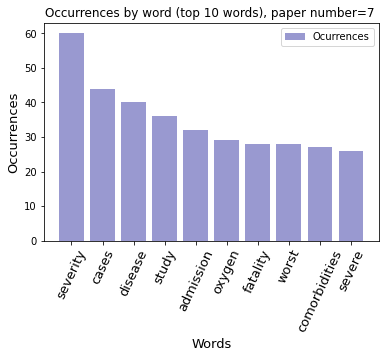

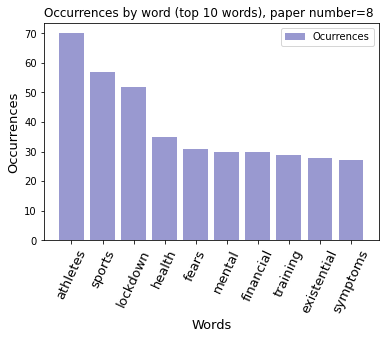

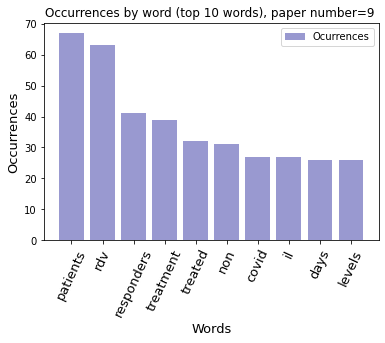

In [15]:
for i in range(10):
    total = list(results[i].keys()), list(results[i].values()) 
    data = pd.DataFrame(total)
    data = data.T
    n_groups = len(data)


    data.columns = ["a","b"]
    data = data.sort_values(["b"],ascending=False)
    data = data.head(10)
    words = data["a"]
    occurences = data["b"]

    fig,ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.25

    opacity = 0.4

    graph = plt.bar(words, occurences,
                alpha=opacity,
                 color='darkblue',
                 label='Ocurrences')


    plt.ylabel('Occurrences',size=13)
    plt.xlabel('Words',size=13)
    plt.xticks(rotation=90,size=13)
    plt.xticks(rotation=65)
    plt.title('Occurrences by word (top 10 words), paper number={} '.format(i),size=12)
    plt.legend()
    plt.show()

#### Reduce phase

In this task, we flatten the resuls(we get rid of the lists), and we use the foldby method of dask.bag to group properly the intermediate pairs in each partitions.

In [16]:
reduce_phase = text_clean.flatten().frequencies(sort=True)

In [17]:
%%time
res_reduce = reduce_phase.compute()

CPU times: user 14.4 s, sys: 876 ms, total: 15.3 s
Wall time: 1min 6s


In [18]:
res_reduce 

[('patients', 25697),
 ('covid', 24107),
 ('study', 18580),
 ('data', 17108),
 ('using', 13588),
 ('used', 13389),
 ('cells', 12964),
 ('health', 12905),
 ('time', 12561),
 ('one', 12262),
 ('cov', 11998),
 ('sars', 11659),
 ('infection', 11627),
 ('two', 10472),
 ('based', 10397),
 ('disease', 10293),
 ('virus', 10157),
 ('results', 10145),
 ('studies', 9953),
 ('model', 9615),
 ('however', 9367),
 ('use', 9307),
 ('analysis', 9200),
 ('high', 9161),
 ('number', 9012),
 ('different', 8884),
 ('cell', 8850),
 ('cases', 8547),
 ('first', 8470),
 ('risk', 8277),
 ('treatment', 8108),
 ('could', 8082),
 ('well', 7997),
 ('viral', 7910),
 ('group', 7900),
 ('clinical', 7860),
 ('table', 7845),
 ('reported', 7838),
 ('care', 7530),
 ('pandemic', 7385),
 ('protein', 7225),
 ('research', 7042),
 ('higher', 6904),
 ('associated', 6766),
 ('information', 6726),
 ('found', 6680),
 ('including', 6654),
 ('patient', 6622),
 ('human', 6529),
 ('control', 6517),
 ('due', 6479),
 ('social', 6411),
 (

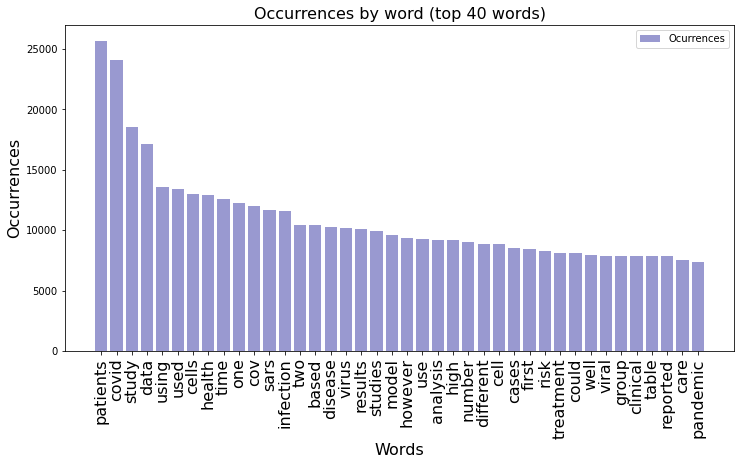

In [19]:
df = pd.DataFrame(res_reduce)
df.columns= ["c","d"]
df = df.sort_values(["d"],ascending=False)
df = df.head(40)
words = df["c"]
occurences = df["d"]

plt.figure(figsize=(12, 6))

bar_width = 0.25
opacity = 0.4

graph = plt.bar(words, occurences,
                alpha=opacity,
                 color='darkblue',
                 label='Ocurrences')


plt.ylabel('Occurrences',size=16)
plt.xlabel('Words',size=16)
plt.xticks(rotation=90,size=16)
plt.title('Occurrences by word (top 40 words)',size=16)
plt.legend()
plt.show()


#### Effect of number of partitions

In [20]:
partition_time = []
partitions = [1,5,10,20,100]
for n in partitions:
    print('number of partitions:',n)
    
    start = time.time()
    
    #import the data
    filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(n)
    
    texts = js.pluck("body_text").map(merge) 
    text_clean = texts.map(cleaner) 
    
    #map_phase
    map_phase = text_clean.map(Counter)
    
    #reduce_phase
    reduce_phase = text_clean.flatten().frequencies(sort=True)
    
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end = time.time()
    
    print('Execution time:',end-start,'\n')
    partition_time.append(end-start)

number of partitions: 1
Execution time: 111.77415657043457 

number of partitions: 5
Execution time: 88.6961920261383 

number of partitions: 10
Execution time: 77.99947428703308 

number of partitions: 20
Execution time: 80.11488246917725 

number of partitions: 100
Execution time: 81.03015661239624 



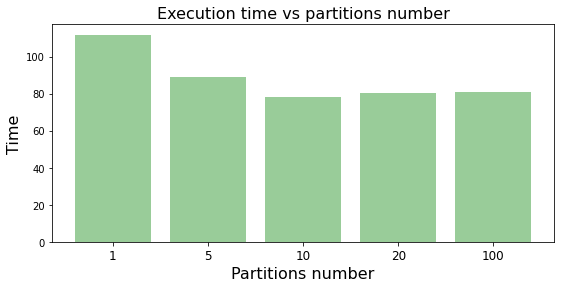

In [21]:
plt.figure(figsize=(9,4))
bar_width = 0.15
plt.bar(range(len(partitions)),partition_time,alpha=0.4,color='g')
plt.xlabel('Partitions number',size=16)
plt.ylabel('Time',size=16)
plt.title('Execution time vs partitions number',size=16)
plt.xticks(range(len(partitions)),partitions,size=12)
plt.show() 

We set the partitions to 1, 5, 10, 20, and 100. We can see that the partitions from 5 to 10 have lesser exucation time as compared to others. According to the plot, the partition = 5 performs the best. 

In [22]:
client.close()

#### Effect of number of workers

In [23]:
worker_time = []
workers = [1,2,3,4]
for w in workers:
    print('Workers:',w)
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    
    start = time.time()
    
    #import the data
    filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(30)
    
    texts = js.pluck("body_text").map(merge)
    text_clean = texts.map(cleaner) 
    
    #map_phase
    map_phase = text_clean.map(Counter)
    
    #reduce_phase
    reduce_phase = text_clean.flatten().frequencies(sort=True)
    
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end = time.time()
    
    print('Execution time:',end-start,'secs','\n') 
    worker_time.append(end-start) 



Workers: 1
Execution time: 127.69771337509155 secs 

Workers: 2


/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33431 instead
  http_address["port"], self.http_server.port


Execution time: 81.2996973991394 secs 

Workers: 3


/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41155 instead
  http_address["port"], self.http_server.port


Execution time: 95.34784984588623 secs 

Workers: 4


/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40249 instead
  http_address["port"], self.http_server.port


Execution time: 105.49451303482056 secs 



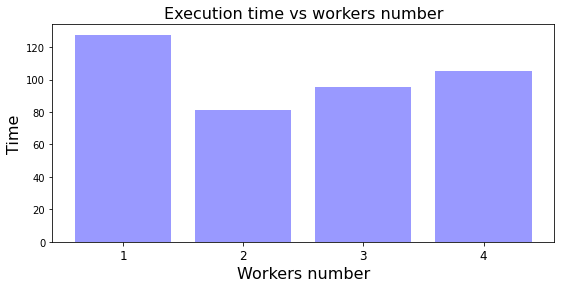

In [24]:
plt.figure(figsize=(9,4))
plt.bar(range(len(workers)),worker_time,alpha=0.4,color='b')
plt.xlabel('Workers number',size=16)
plt.ylabel('Time',size=16)
plt.title('Execution time vs workers number',size=16) 
plt.xticks(range(len(workers)),workers,size=12) 
plt.show()


We can see that the second worker took less time to execute than the first one. 

In [25]:
client.close()

#### Grid search 

We will now perform an analysis of the effects of the parition and worker by creating a Grid Search.

In [26]:
def comp_time(w,p):
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    start = time.time()
    
    #import the data
    filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(p)
    
    texts = js.pluck("body_text").map(merge)
    text_clean = texts.map(cleaner) 
    
    #map_phase
    map_phase = text_clean.map(Counter)
    
    #reduce_phase
    reduce_phase = text_clean.flatten().frequencies(sort=True)
    
     
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end = time.time()
    client.close()
    return end-start

In [27]:
workers = [1,2,3,4]
partitions = [1,5,20,50,100] # with the same partitions as before
                                     #the kernel stop working
t = np.zeros((len(workers),len(partitions)))
for w in range(len(workers)):
    for p in range(len(partitions)):
        t[w][p] = comp_time(workers[w],partitions[p])

/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32823 instead
  http_address["port"], self.http_server.port
/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32805 instead
  http_address["port"], self.http_server.port
/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39175 instead
  http_address["port"], self.http_server.port
/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43135 in

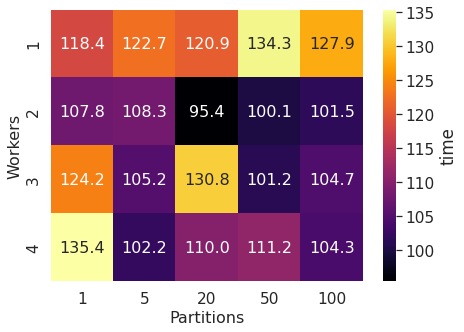

In [28]:
df_grid = pd.DataFrame(t,workers,partitions)
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_grid,annot=True, annot_kws={"size": 16},fmt=".1f",
           cbar_kws={'label':'time'},cmap="inferno")
plt.ylabel('Workers',size=16) 
plt.xlabel('Partitions',size=16)   
plt.show()